In [1]:
import os
os.sys.path

['/gpfs/workdir/liashuhamy/clr',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python37.zip',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/lib-dynload',
 '',
 '/gpfs/users/liashuhamy/.local/lib/python3.7/site-packages',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg',
 '/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/IPython/extensions',
 '/gpfs/users/liashuhamy/.ipython']

In [2]:
os.sys.path.append('/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages')

In [3]:
import numpy as np
import cv2

In [4]:

import tensorflow as tf
print(tf.__version__)

2.3.2


In [5]:
!nvidia-smi

Fri Jul 16 21:58:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:2F:00.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
# from imutils import paths
from tqdm import tqdm
import tensorflow as tf
# import seaborn as sns
import numpy as np
# import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [7]:
# import h5py

# X_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:]
# y_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))

# X_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:]
# y_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [8]:
# from PIL import Image
# def resize(img, size):
#     img = Image.fromarray(img)
#     img = img.resize(size)
#     return np.array(img)

In [9]:
# import cv2
# import numpy as np
# new_x = []
# from tqdm import tqdm
# for i in tqdm(range(X_train.shape[0])):
#     new_x.append(cv2.resize(X_train[i], (224, 224)))
# X_train = np.array(new_x)

# new_x = []
# from tqdm import tqdm
# for i in tqdm(range(X_test.shape[0])):
#     new_x.append(cv2.resize(X_test[i], (224, 224)))
# X_test = np.array(new_x)

# X_train.shape, X_test.shape

In [10]:
# X_train = X_train / 255.
# X_test = X_test / 255.


In [11]:
# _, preprocess_input = Classifiers.get('resnet18')

In [12]:
# X_train[0][:10,:10, 0]

In [13]:
# preprocess_input(X_train[0])[:10,:10, 0]

Data load is here

In [459]:
import h5py

import tensorflow_io as tfio
X_train = tfio.IODataset.from_hdf5('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_train_x.h5', dataset='/x')
y_train = h5py.File('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))
X_test = tfio.IODataset.from_hdf5('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_valid_x.h5', dataset='/x')
y_test = h5py.File('/gpfs/workdir/shared/cpm4c/CAMELYON/prepared_datasets/pre_10_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [45]:
import h5py

import tensorflow_io as tfio
X_train = tfio.IODataset.from_hdf5('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_x.h5', dataset='/x')
y_train = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape((-1,1))
X_test = tfio.IODataset.from_hdf5('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_x.h5', dataset='/x')
y_test = h5py.File('/gpfs/workdir/liashuhamy/camel/raw/pre_9_patient_split_vahadane/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape((-1,1))

In [46]:
y_train.shape[0], y_train.sum(), y_train.shape[0] - y_train.sum()

(95106, 47553, 47553.0)

In [47]:
y_test.shape[0], y_test.sum(), y_test.shape[0] - y_test.sum()

(30296, 15148, 15148.0)

In [48]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


In [17]:
X_train = X_train.map(lambda x: tf.image.resize(x, [112,112]))
X_train = X_train.map(lambda x: tf.cast(x,tf.float32)/255.)
X_train = X_train.map(lambda x: (x - mean)/std)
X_train = (
    X_train
    .batch(33)
    .prefetch(tf.data.experimental.AUTOTUNE)
    
)

In [49]:
X_test = X_test.map(lambda x: tf.image.resize(x, [112,112]))
X_test = X_test.map(lambda x: tf.cast(x,tf.float32)/255.)
X_test = X_test.map(lambda x: (x - mean)/std)
X_test = (
    X_test
    .batch(28)
    .prefetch(tf.data.experimental.AUTOTUNE)
    
)

In [50]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [51]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

/gpfs/users/liashuhamy/.conda/envs/pcamenv/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [52]:
y_train_enc = np.array([[1-i, i] for i in y_train]).reshape((-1,2))
y_test_enc = np.array([[1-i, i] for i in y_test]).reshape((-1,2))

In [53]:
y_train_enc.shape, y_test_enc.shape

((95106, 2), (30296, 2))

In [54]:
y_test_enc[:3], y_test[:3]

(array([[1, 0],
        [0, 1],
        [0, 1]], dtype=uint8),
 array([[0],
        [1],
        [1]], dtype=uint8))

In [55]:
from classification_models.tfkeras import Classifiers
from tensorflow import keras
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    ResNet18, preprocess_input = Classifiers.get('resnet18')#keras.models.load_model('resnet18.h5')
    base_model = keras.models.load_model('resnet18.h5')#ResNet18(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
#     projection_2 = Activation("relu")(projection_2)
#     projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

In [56]:

resnet_simclr = get_resnet_simclr(256,256,256)
resnet_simclr = keras.models.load_model('model_sgd_augm_wfreez_112.h5')

resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 7, 7, 512)         11186112  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
Total params: 11,383,232
Trainable params: 8,590,848
Non-trainable params: 2,792,384
___________________________________

In [57]:
def plot_training(H):
	with plt.xkcd():
# 		plt.plot(H.history["loss"], label="train_loss")
# 		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [58]:

def get_linear_model(features):
    linear_model = Sequential([Dense(2, input_shape=(features, ), activation="softmax")])
    return linear_model

In [59]:
resnet_simclr.layers[1].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
pad (ZeroPadding2D)             (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        pad[0][0]                        
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Total params: 11,186,112
Trainable params: 8,393,728
Non-trainable params: 2,792,384
__________________________________________________________________________________________________


In [60]:
for i, layer in enumerate(resnet_simclr.layers[1].layers):
    print(i, layer.name)

0 input_1
1 pad
2 conv1
3 bn1
4 relu
5 pad1
6 maxpool
7 layer1.0.conv1
8 layer1.0.bn1
9 activation
10 layer1.0.conv2
11 layer1.0.bn2
12 add
13 activation_1
14 layer1.1.conv1
15 layer1.1.bn1
16 activation_2
17 layer1.1.conv2
18 layer1.1.bn2
19 add_1
20 activation_3
21 layer2.0.pad
22 layer2.0.conv1
23 layer2.0.bn1
24 activation_4
25 layer2.0.downsample.0
26 layer2.0.conv2
27 layer2.0.downsample.1
28 layer2.0.bn2
29 add_2
30 activation_5
31 layer2.1.conv1
32 layer2.1.bn1
33 activation_6
34 layer2.1.conv2
35 layer2.1.bn2
36 add_3
37 activation_7
38 layer3.0.pad
39 layer3.0.conv1
40 layer3.0.bn1
41 activation_8
42 layer3.0.downsample.0
43 layer3.0.conv2
44 layer3.0.downsample.1
45 layer3.0.bn2
46 add_4
47 activation_9
48 layer3.1.conv1
49 layer3.1.bn1
50 activation_10
51 layer3.1.conv2
52 layer3.1.bn2
53 add_5
54 activation_11
55 layer4.0.pad
56 layer4.0.conv1
57 layer4.0.bn1
58 activation_12
59 layer4.0.downsample.0
60 layer4.0.conv2
61 layer4.0.downsample.1
62 layer4.0.bn2
63 add_6
64 ac

In [61]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 7, 7, 512)         11186112  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
Total params: 11,383,232
Trainable params: 197,120
Non-trainable params: 11,186,112
____________________________________

In [62]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)


In [63]:
filters = projection.layers[1].layers[2].get_weights()[0]
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [64]:
filters[:,:,:,0]

array([[[0.44786358, 0.4473378 , 0.45237353],
        [0.45016688, 0.43915337, 0.44853982],
        [0.45249277, 0.43484026, 0.46486968],
        [0.49370635, 0.4732586 , 0.5017252 ],
        [0.48390633, 0.47095144, 0.50141406],
        [0.46265116, 0.4538219 , 0.47156158],
        [0.44664064, 0.43962416, 0.4426577 ]],

       [[0.45942476, 0.47803047, 0.46174508],
        [0.4585886 , 0.47153363, 0.44343922],
        [0.39436066, 0.39726388, 0.38576826],
        [0.3026471 , 0.28740293, 0.2945677 ],
        [0.30762768, 0.28542668, 0.31720746],
        [0.38406527, 0.3671651 , 0.3836758 ],
        [0.45547804, 0.45277622, 0.43842414]],

       [[0.44973257, 0.45301563, 0.4587595 ],
        [0.4852366 , 0.50638396, 0.47983718],
        [0.6123398 , 0.6696682 , 0.5701382 ],
        [0.76918745, 0.86766326, 0.6847196 ],
        [0.73290664, 0.83408076, 0.6409633 ],
        [0.5912854 , 0.6517993 , 0.50956285],
        [0.4876473 , 0.5204355 , 0.46336594]],

       [[0.46986744, 0.45032

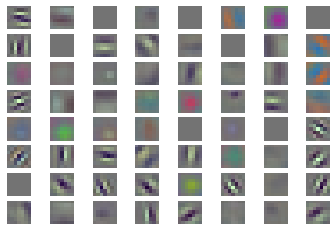

In [65]:
from matplotlib import pyplot as plt
figure, axes = plt.subplots(nrows=8, ncols=8)

i = 0
for x in range(8):
    for y in range(8):
        axes[x, y].imshow(filters[:, :, :, i])
        
        axes[x, y].axis('off')
        i = i + 1
# axes[0, 1].imshow(filters[:, :, :, 1])
# axes[1, 0].imshow(filters[:, :, :, 2])
# axes[1, 1].imshow(filters[:, :, :, 3])
plt.axis('off')
plt.show()

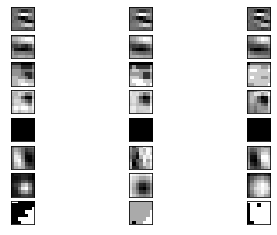

In [66]:
from matplotlib import pyplot
# plot first few filters
n_filters, ix = 8, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
#         plt.figure(figsize=(5,20)) 
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


In [67]:

import time
tic = time.time()
# Extract train and test features
train_features = projection.predict(X_train)
print(train_features.shape)
test_features = projection.predict(X_test)
print(time.time() - tic)

print( test_features.shape)

ValueError: in user code:

    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /gpfs/users/liashuhamy/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer pad is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [256, 256, 3]


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_features1 = scaler.fit_transform(train_features)
# test_features1 = scaler.transform(test_features)

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=2, restore_best_weights=True)

In [ ]:
linear_model = get_linear_model(256)
linear_model.summary()
linear_model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")


In [ ]:
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=30,
                 callbacks=[es])
plot_training(history)

In [ ]:
from sklearn.linear_model import LinearRegression, SGDClassifier
reg = SGDClassifier().fit(train_features, y_train)
reg.score(test_features, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=100).fit(train_features, y_train)
clf.score(test_features, y_test)